# Deep Learning Mini-Challenge 2: Image Captioning

**Task description:** 

**Description of the dataset:** 

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import os

# from torch.ao.quantization.quantize_fx import prepare_fx, prepare_qat_fx, convert_fx
from torch.utils.data import Dataset
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
import torchtext
from tqdm import tqdm

import torchvision.models as models
from torch.nn.utils.rnn import pad_packed_sequence
import random

import wandb
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

import pickle

print(torch.__version__)
print(torchtext.__version__)

c:\Users\samlu\anaconda3\envs\neuerversuchscheisshurensohn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.8.1+cpu
0.9.1


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
image_path = "../../data/Flickr8k/Images/"
label_path = "../../data/Flickr8k/"

In [4]:
def read_labels(label_path, skip_header=True):
    '''
    Reads the labels and caption text from the captions.txt file in the specified path
    '''
    with open(label_path + "captions.txt") as f:
        if skip_header:
            next(f)
        lines = f.readlines()
        lines = [line.replace("\n", "") for line in lines]
        lines = [line.split(".jpg,") for line in lines]
        filenames = [line[0] + ".jpg" for line in lines]
        text = [line[1] for line in lines]
        return(pd.DataFrame([filenames, text], index=(["filename", "text"])).T)

df_caption = read_labels(label_path)
df_caption.head()

,filename,text
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Explorative data analysis

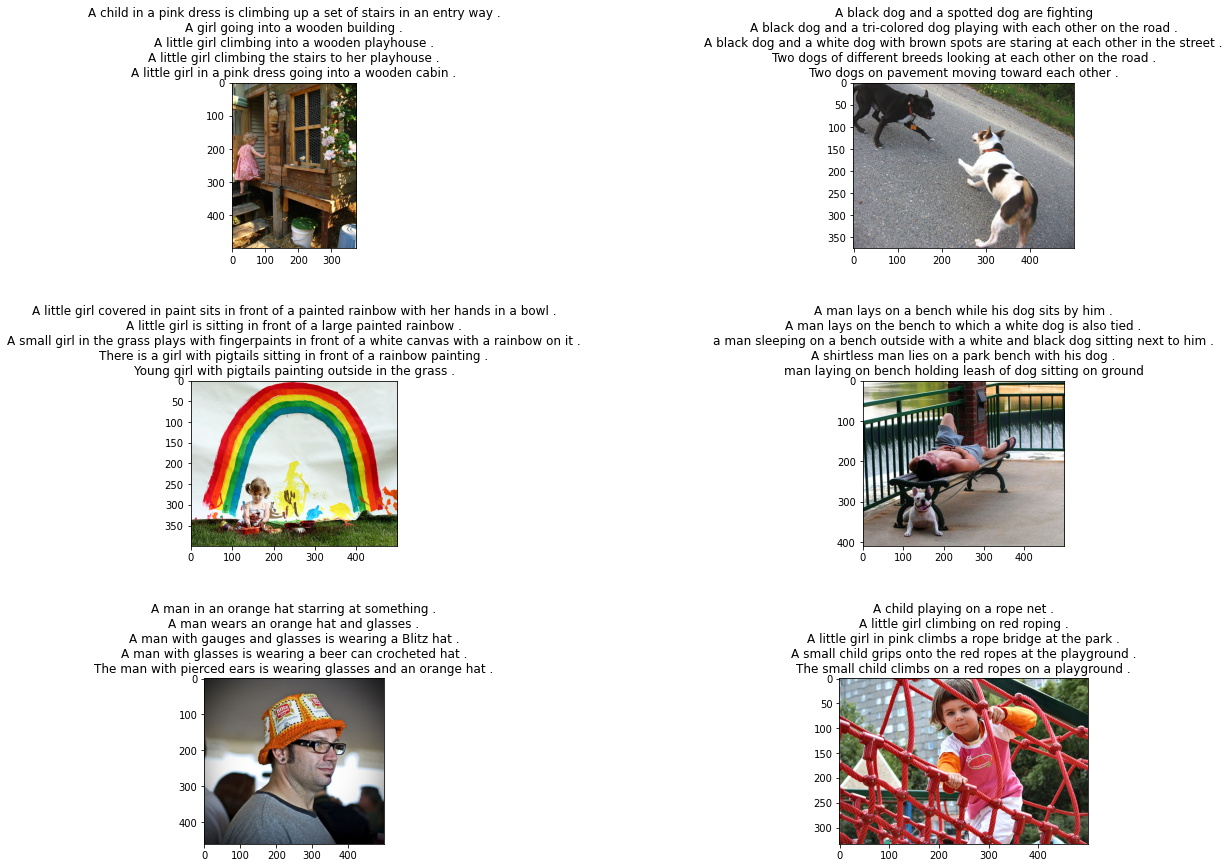

In [5]:
def show_sample_imeages(df, n=3, m=2):
    '''
    Visualises a number of images with the corresponding captions
    '''
    fig, axes = plt.subplots(n, m, figsize=(22,14))
    unique_files = df_caption.filename.unique()

    for i in range(n*m):
        filename = unique_files[i]
        caption = "\n".join(list(df.loc[df["filename"]==unique_files[i]]["text"]))
        img = mpimg.imread(image_path + filename)
        axes[i//m, i%m].imshow(img)
        axes[i//m, i%m].set_title(caption)
    plt.subplots_adjust(hspace = 0.8)
    plt.show()


show_sample_imeages(df_caption)

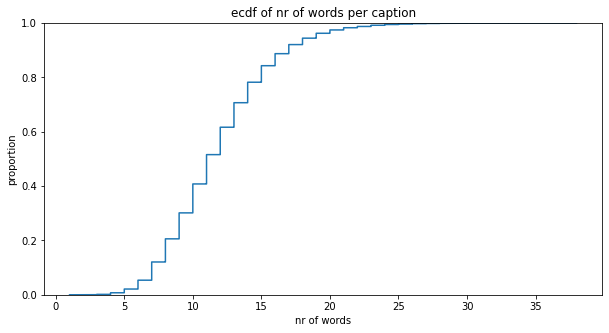

0.50    11.0
0.60    12.0
0.70    13.0
0.80    15.0
0.90    17.0
0.95    19.0
1.00    38.0
Name: text, dtype: float64

In [6]:
plt.figure(figsize=(10,5))
sns.ecdfplot(df_caption.text.apply(str.split).apply(len))
plt.title("ecdf of nr of words per caption")
plt.xlabel("nr of words")
plt.ylabel("proportion")
plt.show()

(df_caption.text.apply(str.split).apply(len)).quantile([.5,.6,.7,.8,.9,.95,1])

In [7]:
def plot_image_sizes(df):
    '''
    Visualizes the height and width of the images in nr of pixels.
    '''
    # read image sizes
    widths, heights = [], []
    for i in range(len(df)):
        filename = df.iloc[i]
        img = mpimg.imread(image_path + filename)
        width, heigth, chanels = np.shape(img)
        widths.append(width)
        heights.append(heigth)

    #create plot
    plt.figure(figsize=(8,8))
    plt.scatter(widths, heights)
    plt.title("Image sizes")
    plt.xlabel("width of images in pixels")
    plt.xlabel("heights of images in pixels")
    plt.show()

unique_filenames = df_caption["filename"].drop_duplicates()
# plot_image_sizes(unique_filenames)

## Preprocessing 

### Preprocessing Images

Preprocessing the images includes the following transformations: 
- `ToPILImage` Transformes the input images to a PIL image which provides the python interpreter with editing capabilities using the **P**ython **I**maging **L**ibrary.
- `CenterCrop` Crops the images from the center, resulting in a fixed image resolution. Images with less pixels than specified recieve a padding of zeros to fill the gap.
- `ToTensor` Trainforms the numpy format to a tensor.

In [8]:
from torchvision.transforms import Compose, CenterCrop, ToTensor, ToPILImage, Normalize

image_transform = Compose([
    ToPILImage(),
    CenterCrop((224, 224)), # resnet18 input shape
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

### Preprocessing Captions

In this section, the captions for the images are preprocessed. The captions are originally provided as strings. In a first step they are processed using the `basic_english` tokenizer included in the torchtext library. It performs several operations such as: lowercasing and replacing certain symbols using a pattern dict. We also limit the maximum number of words per caption to 20, since over 95 percent of all captions are within this range. Sentences with less than 20 words are padded using the `<pad>` token. Finally, we mark the beginning `<bos>` and end `<eos>` with the corresponding tokens, giving all captions a fixed length of 22 tokens.

In [9]:
# define special tokens
start_token = "<bos>"
stop_token = "<eos>"
unknown_token = "<unk>"
padding_token = "<pad>"

# define caption boundaries
max_length  = 20

# specify tokenizer
tokenizer = get_tokenizer('basic_english')

def preprocess_caption(text):
    '''
    Tokenizes the captions and applies preprocessing steps.
    '''
    # tokenize words with torchtext
    tokens = tokenizer(text)
    # cut list length to max_length
    tokens = tokens[:max_length]
    # add start and end token
    tokens = [start_token] + tokens + [stop_token]
    len_tokens = len(tokens)
    #pad to short sentences
    tokens = tokens + [padding_token] * (max_length + 2 - len(tokens))
    return tokens

def add_caption_lengths(text):
    return sum([x != "<pad>" for x in text])

df_caption["text_tokens"] = df_caption["text"].apply(preprocess_caption)

df_caption["caption_length"] = df_caption["text_tokens"].apply(add_caption_lengths) 

### Define Embedding 

https://nlp.stanford.edu/projects/glove/

In [10]:
from collections import Counter, OrderedDict
from torchtext.vocab import Vocab, GloVe

#define embeding method
vectors = "glove.6B.100d"

# define minimal required occurence of words
min_word_count = 3

# count vocabulary
vocab_count = Counter()
for capiton in df_caption["text_tokens"]:
    vocab_count.update(capiton)
sorted_by_freq_tuples = sorted(vocab_count.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# define vocabulary
vocab = Vocab(
    vocab_count,
    vectors=vectors,  
    min_freq=min_word_count, 
    specials=((start_token, stop_token, unknown_token, padding_token)))

# comparison between vocabs
glove = GloVe(name='6B', dim=100)
print("GloVe vocab:", glove.vectors.size())

print("Reduced vocab:", vocab.vectors.size())

GloVe vocab: torch.Size([400000, 100])
Reduced vocab: torch.Size([4094, 100])


**Description:**

In [11]:
def embed_tokens(text):
    '''
    Encodes the tokens from string to integer using our vocabulary
    '''
    return [vocab.stoi[word] for word in text]

def inverse_embed_tokens(text):
    '''
    Encodes the tokens from integer to string using our vocabulary
    '''
    return [vocab.itos[word] for word in text]

text_list = ["<bos>", "Simon", "is", "in", "this", "picture", ":)", "<eos>"]

embedded_text = embed_tokens(text_list)
print("Encoding:", embedded_text)
reconstructed_text = inverse_embed_tokens(embedded_text)
print("Inverse Encoding:", reconstructed_text)

Encoding: [0, 2, 9, 6, 333, 147, 2, 1]
Inverse Encoding: ['<bos>', '<unk>', 'is', 'in', 'this', 'picture', '<unk>', '<eos>']


In [12]:
df_caption["text_encoded"] = df_caption["text_tokens"].apply(embed_tokens)
df_caption[["text", "text_tokens", "text_encoded"]].head()

,text,text_tokens,text_encoded
0,A child in a pink dress is climbing up a set o...,"[<bos>, a, child, in, a, pink, dress, is, clim...","[0, 4, 45, 6, 4, 94, 175, 9, 120, 56, 4, 406, ..."
1,A girl going into a wooden building .,"[<bos>, a, girl, going, into, a, wooden, build...","[0, 4, 21, 316, 67, 4, 200, 119, 5, 1, 3, 3, 3..."
2,A little girl climbing into a wooden playhouse .,"[<bos>, a, little, girl, climbing, into, a, wo...","[0, 4, 42, 21, 120, 67, 4, 200, 2574, 5, 1, 3,..."
3,A little girl climbing the stairs to her playh...,"[<bos>, a, little, girl, climbing, the, stairs...","[0, 4, 42, 21, 120, 7, 394, 23, 65, 2574, 5, 1..."
4,A little girl in a pink dress going into a woo...,"[<bos>, a, little, girl, in, a, pink, dress, g...","[0, 4, 42, 21, 6, 4, 94, 175, 316, 67, 4, 200,..."


**Description:**

### Train-test split

In [13]:
train_files, test_files = train_test_split(unique_filenames, test_size=0.2)

df_train = df_caption.loc[ df_caption["filename"].isin( list(train_files) )]
df_test = df_caption.loc[ df_caption["filename"].isin( list(test_files) )]

train_img_labels = set(df_train["filename"])
test_img_labels = set(df_test["filename"])
print("Proportion of train set:", len(train_img_labels) / (len(train_img_labels) + len(test_img_labels)))
print("Proportion of test set:", len(test_img_labels) / (len(train_img_labels) + len(test_img_labels)))
print("Overlapping labels of train and test set:", sum([label in train_img_labels for label in test_img_labels]))

Proportion of train set: 0.799901124706464
Proportion of test set: 0.20009887529353604
Overlapping labels of train and test set: 0


In [14]:
save_csv = False

if save_csv:
    with open("./train.pickle", 'wb') as f:
        pickle.dump(df_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open("./test.pickle", 'wb') as f:
        pickle.dump(df_test, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open("./train.pickle", 'rb') as f:
        df_train =  pickle.load(f)
    with open("./test.pickle", 'rb') as f:
        df_test =  pickle.load(f)

### Create train and test set

In [15]:
class Flickr8kDataset(Dataset):
    
    def __init__(self, df, image_path, transform=None, preload=False):
        """
        Args:
            df (pandas DataFrame): contains the filenames and the captions of the pictures
            transform (callable, optional): Optional transform to apply on the images
        """
        self.df = df
        self.transform = transform
        self.preload = preload

        if self.preload:
            self.images = []
            for filename in tqdm(np.unique(df['filename'])):
                image = mpimg.imread(image_path + filename)
                if self.transform:
                    image = self.transform(image)
                self.images.append(image)

            self.df['image_idx'] = df.groupby('filename').ngroup()

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        df_row = self.df.iloc[idx, :]

        if self.preload:
            image_id = self.df.iloc[idx]['image_idx']
            image = self.images[image_id]
        else:
            image = mpimg.imread(image_path + df_row['filename'])
            if self.transform:
                image = self.transform(image)

        caption = torch.from_numpy(np.array(df_row['text_encoded']))
        length = torch.from_numpy(np.array(df_row['caption_length']))
        return image, caption, length
        


In [16]:
train_set = Flickr8kDataset(df_train, image_path, transform=image_transform, preload=True)
test_set = Flickr8kDataset(df_test, image_path, transform=image_transform, preload=True)

100%|██████████| 1619/1619 [00:07<00:00, 212.01it/s]


### Define the dataloader

In [17]:
# Set seed 
torch.manual_seed(42)
batch_size = 64

train_dataloader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    shuffle=False)

In [18]:
example_batch = iter(train_dataloader)
samples, labels, length = example_batch.next()
np.shape(labels)

torch.Size([64, 22])

### Define models

In [19]:


class EncoderCNN(nn.Module):

    def __init__(self, embed_size, train_cnn=False):
        '''
        Args:
            embed_size (int)
            train_cnn (bool) if true trains the complete network
            dropout (float): dropout ratio after the last layer
        '''
        super(EncoderCNN, self).__init__()
        self.train_cnn = train_cnn
        self.cnn_model = models.resnet18(pretrained=True)
        self.cnn_model.fc = nn.Linear(self.cnn_model.fc.in_features, embed_size) # resize outout shape
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        features = self.cnn_model(images)

        # specify if the complete network should be trained or only the last one
        for name, param in self.cnn_model.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_cnn
        return self.bn(self.relu(features))



class DecoderRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0, pretrained_emb=False):
        super(DecoderRNN, self).__init__()
        if pretrained_emb:
            self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size) # ????????????????
        
        self.lstm = nn.LSTM(input_size=embed_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            # batch_first=True
                            )
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, features, captions, lengths):
        # print("captions shape", np.shape(captions))
        # embedding of captions
        embeddings = self.dropout(self.embedding(captions))
        # print("Embedded captions shape", np.shape(embeddings))
        # print("features shape", np.shape(features))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        packed = pack_padded_sequence(embeddings, lengths, enforce_sorted=False, batch_first=True)

        output_packed, hidden = self.lstm(packed) #(1, batch size, len_embedding)
        output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)
        
        outputs = self.linear(output_padded)
        return outputs



class CNNtoRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0, pretrained_emb=False):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size=embed_size)
        self.decoderRNN = DecoderRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, num_layers=num_layers)

    def forward(self, images, capitons, lengths):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, capitons, lengths)
        return outputs

    def caption_images(self, image, vocabulary, max_length = 30):
        '''Creates a caption for a single image'''
        caption_result = []
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
       
            for _ in range(max_length):
                hidden, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hidden.squeeze(0))
                predicted = output.argmax(1)

                caption_result.append(predicted.item())
                x = self.decoderRNN.embedding(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<eos>":
                    break
            return "".join([vocabulary.itos[idx] + " " for idx in caption_result])



def caption_image(model, path=image_path, filename=None, transform=image_transform):
    '''
    Creates a caption for a single image
    Args:
        model (CNNtoRNN): model class
        path (str): path to image folder
        filename (str): name of image, if None a random image is selected
        transform (torchvision.transforms.Compose): the transformations of the image before feeding into the model
    '''
    model.eval()
    if not filename:
        filename = random.choice(os.listdir(path))
    image = mpimg.imread(path + filename)
    if transform is not None:
        image_tensor = transform(image)
    with torch.no_grad():
        image_tensor = (image_tensor[None, ...]).to(device)
        return filename, image, model.caption_images(image_tensor, vocab)  

def func_save_model(model, path, name):
        '''
        Saves the model as state dict.
        Args:
            model (CNNtoRNN): the model class
            path (str): path where to save the model
            name of the document
        '''
        filename = "{}.pt".format(name)
        print(filename)
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(model, path + filename)

def func_save_log(log_dict, name):
    with open('{}.pickle'.format(name), 'wb') as f:
        pickle.dump(log_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

def func_open_log(name):
    with open('{}.pickle'.format(name), 'rb') as f:
        return pickle.load(f)


In [20]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence
import pickle
import wandb

# wandb
use_wandb=False
# model loading & saving
load_model = True
save_model = True
model_path = "./saved_models/"
model_name = "pretrained_embedding"
# training hyperparameters
pretrained_emb = True
embed_size=100
hidden_size = 100
vocab_size = vocab.vectors.size()[0]
num_layers = 1
learning_rate = 0.003
num_epochs=40
# BLEU evaluation
include_bleu_test_score = True
n_samples = 64 # nr of random samples for BLEU score


# define training modules
if load_model:
    log_dict = func_open_log(model_name)
    step = log_dict[max(int(k) for k in log_dict.keys())]["step"]
    model = torch.load(model_path + "{}_e{}.pt".format(model_name, len(log_dict)), map_location=device)
else: 
    log_dict = dict()
    step = 0
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers, pretrained_emb).to(device)

criterion = nn.CrossEntropyLoss() # ignore_index
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
if use_wandb:
    wandb.init(reinit=True, project="del_mc2", entity="simonluder")


for epoch in range(len(log_dict)+1,len(log_dict)+1+num_epochs):
    print("epoch:", epoch)
    cumloss = 0

    model.train()
    for i, (imgs, captions, lengths) in tqdm(enumerate(train_dataloader)):
        
        step += len(imgs)
        # print(np.shape(imgs), np.shape(captions))
        imgs = imgs.to(device)
        captions = captions.to(device)
        # targets = pack_padded_sequence(captions, length, batch_first=True)[0]

        packed_captions = pack_padded_sequence(captions, lengths, enforce_sorted=False, batch_first=True)[0]
        # print(targets)
        outputs = model(imgs, captions[:,:-1], lengths)
        packed_outputs = pack_padded_sequence(outputs, lengths, enforce_sorted=False, batch_first=True)[0]
        # print("packed_captions", np.shape(packed_captions))
        # print("packed_outputs", np.shape(packed_outputs))
        
        # print(np.shape(captions.reshape(-1)))
        # # outputs = pack_padded_sequence(outputs, lengths.tolist(), enforce_sorted=False, batch_first=True)[0]
        # print(np.shape(outputs.reshape(-1, outputs.shape[2])))
        # print(np.shape(targets))
        # # loss = criterion(outputs, targets)
        # loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1).type(torch.long))
        loss = criterion(packed_outputs, packed_captions.type(torch.long))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumloss += loss.item()

        if i % 10 == 0 and use_wandb:
            wandb.log({
                "model":model_name,
                "train_loss": loss,
                "epoch":epoch+1, 
                }, step=step)

    model.eval()   
    # calculate BLEU
    if include_bleu_test_score:
        mean_bleu = 0
        for j, file in enumerate(random.sample(list(set(df_test["filename"])), n_samples)):
            (file, _, caption) = caption_image(model)
            train_captions = df_caption.loc[df_caption["filename"]==file]["text"].apply(str.split).to_list()
            mean_bleu += sentence_bleu(train_captions, caption.split()[1:-1])
        mean_bleu /= n_samples

        
    log_dict[epoch] = {
        "step":step, 
        "train_loss":cumloss,
        "test_bleu":mean_bleu
        }

    # save the model at the end of the epoch
    func_save_model(model, model_path, "{}_e{}".format(model_name, epoch))
    func_save_log(log_dict, model_name)


epoch: 33


506it [16:03,  1.90s/it]
c:\Users\samlu\anaconda3\envs\neuerversuchscheisshurensohn\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\samlu\anaconda3\envs\neuerversuchscheisshurensohn\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\samlu\anaconda3\envs\neuerversuchscheisshurensohn\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independentl

pretrained_embedding_e33.pt
epoch: 34


506it [15:49,  1.88s/it]


pretrained_embedding_e34.pt
epoch: 35


506it [15:48,  1.88s/it]


pretrained_embedding_e35.pt
epoch: 36


506it [15:50,  1.88s/it]


pretrained_embedding_e36.pt
epoch: 37


506it [15:51,  1.88s/it]


pretrained_embedding_e37.pt
epoch: 38


506it [15:47,  1.87s/it]


pretrained_embedding_e38.pt
epoch: 39


506it [15:45,  1.87s/it]


pretrained_embedding_e39.pt
epoch: 40


506it [15:45,  1.87s/it]


pretrained_embedding_e40.pt
epoch: 41


506it [15:43,  1.87s/it]


pretrained_embedding_e41.pt
epoch: 42


506it [15:46,  1.87s/it]


pretrained_embedding_e42.pt
epoch: 43


506it [15:46,  1.87s/it]


pretrained_embedding_e43.pt
epoch: 44


506it [15:46,  1.87s/it]


pretrained_embedding_e44.pt
epoch: 45


506it [15:52,  1.88s/it]


pretrained_embedding_e45.pt
epoch: 46


506it [15:48,  1.88s/it]


pretrained_embedding_e46.pt
epoch: 47


506it [15:48,  1.87s/it]


pretrained_embedding_e47.pt
epoch: 48


506it [15:46,  1.87s/it]


pretrained_embedding_e48.pt
epoch: 49


506it [15:47,  1.87s/it]


pretrained_embedding_e49.pt
epoch: 50


506it [15:47,  1.87s/it]


pretrained_embedding_e50.pt
epoch: 51


506it [15:47,  1.87s/it]


pretrained_embedding_e51.pt
epoch: 52


506it [16:10,  1.92s/it]


pretrained_embedding_e52.pt
epoch: 53


506it [15:47,  1.87s/it]


pretrained_embedding_e53.pt
epoch: 54


506it [15:48,  1.87s/it]


pretrained_embedding_e54.pt
epoch: 55


506it [15:50,  1.88s/it]


pretrained_embedding_e55.pt
epoch: 56


506it [15:50,  1.88s/it]


pretrained_embedding_e56.pt
epoch: 57


506it [15:53,  1.88s/it]


pretrained_embedding_e57.pt
epoch: 58


506it [15:49,  1.88s/it]


pretrained_embedding_e58.pt
epoch: 59


506it [15:43,  1.86s/it]


pretrained_embedding_e59.pt
epoch: 60


506it [15:49,  1.88s/it]


pretrained_embedding_e60.pt
epoch: 61


506it [15:52,  1.88s/it]


pretrained_embedding_e61.pt
epoch: 62


506it [15:49,  1.88s/it]


pretrained_embedding_e62.pt
epoch: 63


506it [15:50,  1.88s/it]


pretrained_embedding_e63.pt
epoch: 64


506it [15:51,  1.88s/it]


pretrained_embedding_e64.pt
epoch: 65


506it [15:51,  1.88s/it]


pretrained_embedding_e65.pt
epoch: 66


506it [15:52,  1.88s/it]


pretrained_embedding_e66.pt
epoch: 67


506it [15:52,  1.88s/it]


pretrained_embedding_e67.pt
epoch: 68


506it [15:53,  1.89s/it]


pretrained_embedding_e68.pt
epoch: 69


506it [15:55,  1.89s/it]


pretrained_embedding_e69.pt
epoch: 70


506it [15:53,  1.88s/it]


pretrained_embedding_e70.pt
epoch: 71


506it [15:52,  1.88s/it]


pretrained_embedding_e71.pt
epoch: 72


506it [15:55,  1.89s/it]


pretrained_embedding_e72.pt


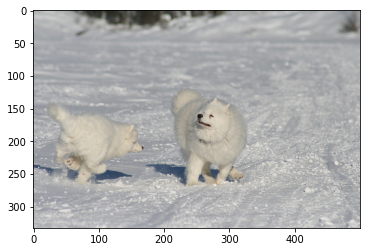

Captioning image: 2319175397_3e586cfaf8.jpg
Caption sencence: <bos> two white dogs are running in the snow . <eos> 
BLEU score: 0.7905694150420948


In [36]:
(file, image, caption) = caption_image(model)
plt.imshow(image)
plt.show()
print("Captioning image: {}".format(file))  
print("Caption sencence:", caption)

caption.split()[1:-1]
train_captions = df_caption.loc[df_caption["filename"]==file]["text"].apply(str.split).to_list()

bleu =  sentence_bleu(train_captions, caption.split()[1:-1], weights=(1/2, 1/2))
print("BLEU score:",bleu, )

In [22]:
log_dict = func_open_log(model_name)
log_dict

{1: {'step': 32360,
  'train_loss': 1838.0492310523987,
  'test_bleu': 0.03228413723798662},
 2: {'step': 64720,
  'train_loss': 1455.8457357883453,
  'test_bleu': 0.027894639221831313},
 3: {'step': 97080,
  'train_loss': 1347.1153132915497,
  'test_bleu': 0.0523670944472838},
 4: {'step': 129440,
  'train_loss': 1278.737820148468,
  'test_bleu': 0.045491756068982515},
 5: {'step': 161800,
  'train_loss': 1229.032351732254,
  'test_bleu': 0.06315797009250969},
 6: {'step': 194160,
  'train_loss': 1188.770180940628,
  'test_bleu': 0.029332000286607905},
 7: {'step': 226520,
  'train_loss': 1155.2977933883667,
  'test_bleu': 0.06988254206458978},
 8: {'step': 258880,
  'train_loss': 1126.1851316690445,
  'test_bleu': 0.05880518684098864},
 9: {'step': 291240,
  'train_loss': 1099.8934532403946,
  'test_bleu': 0.05846294768123684},
 10: {'step': 323600,
  'train_loss': 1077.4864341020584,
  'test_bleu': 0.052102635881444134},
 11: {'step': 355960,
  'train_loss': 1076.9475710391998,
  't

In [23]:
test_bleu = []
epochs = []
train_losses = []

for i in range(1, len(log_dict)+1):
    test_bleu.append(log_dict[i]["test_bleu"])
    epochs.append(i)
    train_losses.append(log_dict[i]["train_loss"])


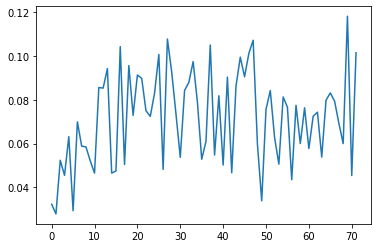

In [24]:
plt.plot(test_bleu)

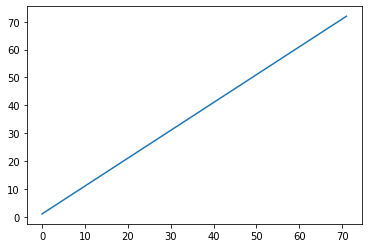

In [25]:
plt.plot(epochs)

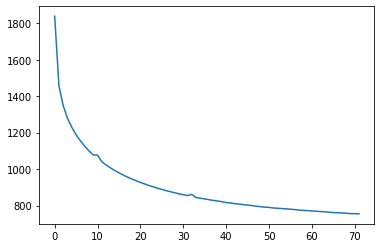

In [26]:
plt.plot(train_losses)